In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster
from sklearn.metrics.pairwise import haversine_distances
from math import radians, sin, cos, sqrt, atan2
from geopy.distance import geodesic
import fiona
from shapely.geometry import Point
from geopy.geocoders import Nominatim

all_uni_locations Sourced: https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::colleges-and-universities/about
hbcus Sourced: https://nces.ed.gov/ipeds/datacenter/InstitutionByName.aspx?goToReportId=1&sid=1214ca4d-d341-4739-af2b-bb571778daae&rtid=1

In [2]:
all_uni_locations= pd.read_csv('../data/Colleges_and_Universities.csv')
hbcus= pd.read_csv('../data/hbcu_list.csv')

In [3]:
hbcu_merged=all_uni_locations.merge(hbcus, left_on='IPEDSID', right_on='unitid')
hbcu_merged

,X,Y,OBJECTID,IPEDSID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,TOT_EMP,SHELTER_ID,unitid,institution_name,year,HD2022.Historically Black College or University,agency_id,campus_agency,city_agency,county_agency
0,-8.425464e+06,4.609303e+06,22,163338,UNIVERSITY OF MARYLAND EASTERN SHORE,J.T. WILLIAMS HALL,PRINCESS ANNE,MD,21853,1299,...,765,NOT AVAILABLE,163338,University of Maryland Eastern Shore,2022,Yes,8029.0,y,n,n
1,-9.802458e+06,3.593069e+06,27,102030,BISHOP STATE COMMUNITY COLLEGE,351 NORTH BROAD STREET,MOBILE,AL,36603,5898,...,290,NOT AVAILABLE,102030,Bishop State Community College,2022,Yes,23089.0,y,n,n
2,-9.382946e+06,3.558622e+06,146,133650,FLORIDA AGRICULTURAL AND MECHANICAL UNIVERSITY,1500 S MARTIN LUTHER KING JR BLVD,TALLAHASSEE,FL,32307,NOT AVAILABLE,...,1830,NOT AVAILABLE,133650,Florida Agricultural and Mechanical University,2022,Yes,2920.0,n,y,n
3,-1.095974e+07,3.428517e+06,325,227854,ST PHILIP'S COLLEGE,1801 MARTIN LUTHER KING DR,SAN ANTONIO,TX,78203,2098,...,836,NOT AVAILABLE,227854,St Philip's College,2022,Yes,19871.0,n,y,n
4,-8.407892e+06,4.856108e+06,413,211608,CHEYNEY UNIVERSITY OF PENNSYLVANIA,1837 UNIVERSITY CIRCLE,CHEYNEY,PA,19319,0200,...,136,NOT AVAILABLE,211608,Cheyney University of Pennsylvania,2022,Yes,16403.0,n,n,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-8.752139e+06,4.271082e+06,6089,199582,SAINT AUGUSTINE'S UNIVERSITY,1315 OAKWOOD AVENUE,RALEIGH,NC,27610,2298,...,295,NOT AVAILABLE,199582,Saint Augustine's University,2022,Yes,11607.0,n,y,n
97,-8.782952e+06,4.297077e+06,6200,199157,NORTH CAROLINA CENTRAL UNIVERSITY,1801 FAYETTEVILLE STREET,DURHAM,NC,27707,NOT AVAILABLE,...,1404,NOT AVAILABLE,199157,North Carolina Central University,2022,Yes,11118.0,y,n,n
98,-1.044562e+07,3.835148e+06,6204,160649,SOUTHERN UNIVERSITY AT SHREVEPORT,3050 MARTIN LUTHER KING DR,SHREVEPORT,LA,71107,NOT AVAILABLE,...,338,NOT AVAILABLE,160649,Southern University at Shreveport,2022,Yes,7171.0,n,n,y
99,-8.930586e+06,4.312610e+06,6218,199999,WINSTON-SALEM STATE UNIVERSITY,601 MARTIN LUTHER KING JR DR,WINSTON-SALEM,NC,27110,0001,...,951,NOT AVAILABLE,199999,Winston-Salem State University,2022,Yes,11135.0,n,y,n


In [4]:
hbcu_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 53 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   X                                                101 non-null    float64
 1   Y                                                101 non-null    float64
 2   OBJECTID                                         101 non-null    int64  
 3   IPEDSID                                          101 non-null    int64  
 4   NAME                                             101 non-null    object 
 5   ADDRESS                                          101 non-null    object 
 6   CITY                                             101 non-null    object 
 7   STATE                                            101 non-null    object 
 8   ZIP                                              101 non-null    int64  
 9   ZIP4                            

In [5]:
hbcu_locs=folium.Map(location=[30.4275125,	-84.28844136], zoom_start=5, min_zoom=4, max_zoom=25)
for row_index, row_values in hbcu_merged.iterrows():
    loc = [row_values['LATITUDE'], row_values['LONGITUDE']]
    pop = str(row_values['institution_name'])
    icon=folium.Icon(color="black",icon="fa-solid fa-building-columns" , prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
        icon = icon) 

    marker.add_to(hbcu_locs)
hbcu_locs.save('../maps/hbcu_locs.html')

hbcu_locs

In [6]:
school_stats= pd.read_csv('../data/school_data/Statistics.csv')
school_stats

,Variable,AVG,Unnamed: 2
0,Average net price-students awarded grant or sc...,"11,229",NaN
1,Number of students receiving a Doctor's degree...,34,NaN
2,Number of students receiving a Master's degree...,84,NaN
3,Number of students receiving a Bachelor's degr...,363,NaN
4,Number of students receiving an Associate's de...,51,NaN
5,Percent of full-time first-time undergraduates...,77,NaN
6,Average amount of federal grant aid awarded to...,"6,705",NaN
7,Percent of full-time first-time undergraduates...,71,NaN
8,Average amount of Pell grant aid awarded to fu...,"5,470",NaN
9,Percent of full-time first-time undergraduates...,44,NaN


In [7]:
outcomes= pd.read_csv('../data/school_data/outcome_statistics.csv')
outcomes

,Variable,AVG,Unnamed: 2
0,Percent full-time first-time receiving an awar...,19,NaN
1,Percent full-time first-time receiving an awar...,32,NaN
2,Percent full-time first-time receiving an awar...,33,NaN
3,Percent full-time first-time still enrolled at...,1,NaN
4,Percent full-time first-time subsequently enro...,26,NaN
5,Percent full-time first-time receiving an asso...,6,NaN
6,Percent full-time first-time receiving a bache...,33,NaN
7,"Percent full-time first-time, Pell grant recip...",17,NaN
8,"Percent full-time first-time, Pell grant recip...",30,NaN
9,"Percent full-time first-time, Pell grant recip...",31,NaN


In [8]:
school_grads= pd.read_csv('../data/school_data/graduation_by_school.csv')
school_grads

,UnitID,Institution Name,Graduation rate total cohort (DRVGR2021_RV),Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Transfer-out rate - Bachelor cohort (DRVGR2021_RV),Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
0,100654,Alabama A & M University,28.0,11.0,24.0,28.0,34.0,28.0,32.0,32.0,27.0,27.0,NaN
1,100724,Alabama State University,28.0,10.0,23.0,28.0,36.0,26.0,40.0,40.0,32.0,32.0,NaN
2,138716,Albany State University,24.0,11.0,30.0,35.0,39.0,34.0,27.0,39.0,27.0,36.0,NaN
3,175342,Alcorn State University,42.0,33.0,41.0,42.0,NaN,38.0,38.0,38.0,65.0,65.0,NaN
4,217624,Allen University,23.0,9.0,20.0,23.0,17.0,22.0,38.0,38.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,237899,West Virginia State University,30.0,18.0,28.0,30.0,20.0,29.0,14.0,14.0,37.0,37.0,NaN
97,206491,Wilberforce University,18.0,7.0,16.0,18.0,NaN,19.0,25.0,25.0,11.0,11.0,NaN
98,229887,Wiley College,27.0,13.0,24.0,27.0,39.0,23.0,50.0,50.0,67.0,67.0,NaN
99,199999,Winston-Salem State University,46.0,28.0,44.0,46.0,26.0,44.0,53.0,53.0,53.0,53.0,NaN


In [9]:
school_grads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 13 columns):
 #   Column                                                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                                                    --------------  -----  
 0   UnitID                                                                                                                                    101 non-null    int64  
 1   Institution Name                                                                                                                          101 non-null    object 
 2   Graduation rate  total cohort (DRVGR2021_RV)                                                                                              98 non-null     float64
 3   Graduation rate - Bachelor degree within 4 years  total

In [10]:
top_10_4yr_grad_rates = school_grads.nlargest(10, school_grads.columns[3])
top_10_4yr_grad_rates

,UnitID,Institution Name,Graduation rate total cohort (DRVGR2021_RV),Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Transfer-out rate - Bachelor cohort (DRVGR2021_RV),Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
79,141060,Spelman College,76.0,66.0,73.0,76.0,14.0,73.0,76.0,76.0,84.0,84.0,NaN
35,131520,Howard University,64.0,53.0,62.0,64.0,23.0,58.0,68.0,68.0,69.0,69.0,NaN
22,158802,Dillard University,52.0,40.0,49.0,52.0,NaN,50.0,62.0,62.0,62.0,62.0,NaN
33,232265,Hampton University,57.0,40.0,54.0,57.0,31.0,47.0,67.0,67.0,64.0,62.0,NaN
15,217873,Claflin University,51.0,38.0,48.0,51.0,25.0,47.0,54.0,54.0,78.0,78.0,NaN
26,220181,Fisk University,46.0,38.0,44.0,45.0,28.0,38.0,36.0,36.0,67.0,65.0,NaN
100,160904,Xavier University of Louisiana,50.0,37.0,46.0,48.0,35.0,40.0,44.0,46.0,70.0,69.0,NaN
3,175342,Alcorn State University,42.0,33.0,41.0,42.0,NaN,38.0,38.0,38.0,65.0,65.0,NaN
20,130934,Delaware State University,47.0,33.0,44.0,47.0,9.0,45.0,51.0,51.0,51.0,51.0,NaN
53,140553,Morehouse College,47.0,33.0,43.0,47.0,31.0,40.0,52.0,52.0,60.0,60.0,NaN


In [11]:
top_10_5yr_grad_rates = school_grads.nlargest(10, school_grads.columns[4])
top_10_5yr_grad_rates

,UnitID,Institution Name,Graduation rate total cohort (DRVGR2021_RV),Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Transfer-out rate - Bachelor cohort (DRVGR2021_RV),Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
79,141060,Spelman College,76.0,66.0,73.0,76.0,14.0,73.0,76.0,76.0,84.0,84.0,NaN
35,131520,Howard University,64.0,53.0,62.0,64.0,23.0,58.0,68.0,68.0,69.0,69.0,NaN
33,232265,Hampton University,57.0,40.0,54.0,57.0,31.0,47.0,67.0,67.0,64.0,62.0,NaN
22,158802,Dillard University,52.0,40.0,49.0,52.0,NaN,50.0,62.0,62.0,62.0,62.0,NaN
27,133650,Florida Agricultural and Mechanical University,55.0,28.0,49.0,55.0,22.0,53.0,63.0,63.0,61.0,61.0,NaN
15,217873,Claflin University,51.0,38.0,48.0,51.0,25.0,47.0,54.0,54.0,78.0,78.0,NaN
58,199102,North Carolina A & T State University,53.0,29.0,48.0,53.0,24.0,50.0,57.0,57.0,59.0,59.0,NaN
59,199157,North Carolina Central University,51.0,29.0,47.0,51.0,23.0,50.0,55.0,55.0,51.0,51.0,NaN
60,101912,Oakwood University,49.0,27.0,47.0,49.0,NaN,40.0,51.0,51.0,69.0,69.0,NaN
47,213598,Lincoln University,49.0,32.0,46.0,49.0,29.0,45.0,51.0,51.0,70.0,70.0,NaN


In [12]:
top_10_6yr_grad_rates = school_grads.nlargest(10, school_grads.columns[5])
top_10_6yr_grad_rates

,UnitID,Institution Name,Graduation rate total cohort (DRVGR2021_RV),Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Transfer-out rate - Bachelor cohort (DRVGR2021_RV),Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
17,217891,Clinton College,38.0,0.0,40.0,80.0,NaN,75.0,50.0,NaN,100.0,100.0,NaN
79,141060,Spelman College,76.0,66.0,73.0,76.0,14.0,73.0,76.0,76.0,84.0,84.0,NaN
78,228486,Southwestern Christian College,11.0,33.0,33.0,67.0,NaN,0.0,20.0,100.0,3.0,100.0,NaN
35,131520,Howard University,64.0,53.0,62.0,64.0,23.0,58.0,68.0,68.0,69.0,69.0,NaN
33,232265,Hampton University,57.0,40.0,54.0,57.0,31.0,47.0,67.0,67.0,64.0,62.0,NaN
87,102377,Tuskegee University,57.0,27.0,44.0,57.0,NaN,65.0,63.0,63.0,51.0,51.0,NaN
27,133650,Florida Agricultural and Mechanical University,55.0,28.0,49.0,55.0,22.0,53.0,63.0,63.0,61.0,61.0,NaN
58,199102,North Carolina A & T State University,53.0,29.0,48.0,53.0,24.0,50.0,57.0,57.0,59.0,59.0,NaN
22,158802,Dillard University,52.0,40.0,49.0,52.0,NaN,50.0,62.0,62.0,62.0,62.0,NaN
15,217873,Claflin University,51.0,38.0,48.0,51.0,25.0,47.0,54.0,54.0,78.0,78.0,NaN


In [13]:
top_10_overall_grad_rates = school_grads.nlargest(10, school_grads.columns[2])
top_10_overall_grad_rates

,UnitID,Institution Name,Graduation rate total cohort (DRVGR2021_RV),Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Transfer-out rate - Bachelor cohort (DRVGR2021_RV),Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
79,141060,Spelman College,76.0,66.0,73.0,76.0,14.0,73.0,76.0,76.0,84.0,84.0,NaN
35,131520,Howard University,64.0,53.0,62.0,64.0,23.0,58.0,68.0,68.0,69.0,69.0,NaN
33,232265,Hampton University,57.0,40.0,54.0,57.0,31.0,47.0,67.0,67.0,64.0,62.0,NaN
87,102377,Tuskegee University,57.0,27.0,44.0,57.0,NaN,65.0,63.0,63.0,51.0,51.0,NaN
27,133650,Florida Agricultural and Mechanical University,55.0,28.0,49.0,55.0,22.0,53.0,63.0,63.0,61.0,61.0,NaN
58,199102,North Carolina A & T State University,53.0,29.0,48.0,53.0,24.0,50.0,57.0,57.0,59.0,59.0,NaN
22,158802,Dillard University,52.0,40.0,49.0,52.0,NaN,50.0,62.0,62.0,62.0,62.0,NaN
15,217873,Claflin University,51.0,38.0,48.0,51.0,25.0,47.0,54.0,54.0,78.0,78.0,NaN
59,199157,North Carolina Central University,51.0,29.0,47.0,51.0,23.0,50.0,55.0,55.0,51.0,51.0,NaN
100,160904,Xavier University of Louisiana,50.0,37.0,46.0,48.0,35.0,40.0,44.0,46.0,70.0,69.0,NaN


In [14]:
enroll_degree_count= pd.read_csv('../data/school_data/enroll_degree_count.csv')
enroll_degree_count

,UnitID,Institution Name,Number of students receiving a Doctor's degree (DRVC2022),Number of students receiving a Master's degree (DRVC2022),Number of students receiving a Bachelor's degree (DRVC2022),Number of students receiving an Associate's degree (DRVC2022),Undergraduate enrollment (DRVEF2021_RV),Full-time undergraduate enrollment (DRVEF2021_RV),Total enrollment (DRVEF2021_RV),Full-time enrollment (DRVEF2021_RV),Institution size category (HD2021),Unnamed: 11
0,100654,Alabama A & M University,9.0,249.0,511.0,0,5107,4529,5969,5064,3,NaN
1,100724,Alabama State University,24.0,119.0,480.0,0,3499,3055,3964,3378,2,NaN
2,138716,Albany State University,0.0,148.0,580.0,698,5824,3880,6297,4140,3,NaN
3,175342,Alcorn State University,7.0,145.0,608.0,23,2533,2131,3074,2302,2,NaN
4,217624,Allen University,0.0,14.0,62.0,0,563,544,621,578,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
96,237899,West Virginia State University,0.0,66.0,334.0,0,3281,1317,3415,1392,2,NaN
97,206491,Wilberforce University,0.0,5.0,68.0,0,544,381,557,389,1,NaN
98,229887,Wiley College,0.0,0.0,107.0,7,665,584,665,584,1,NaN
99,199999,Winston-Salem State University,59.0,132.0,930.0,0,4726,3961,5226,4322,3,NaN


In [15]:
enroll_degree_count['undergrad_enrollment_graduation_percent_22'] = (enroll_degree_count.iloc[:, 4] / enroll_degree_count.iloc[:, 6]) * 100
enroll_degree_count

,UnitID,Institution Name,Number of students receiving a Doctor's degree (DRVC2022),Number of students receiving a Master's degree (DRVC2022),Number of students receiving a Bachelor's degree (DRVC2022),Number of students receiving an Associate's degree (DRVC2022),Undergraduate enrollment (DRVEF2021_RV),Full-time undergraduate enrollment (DRVEF2021_RV),Total enrollment (DRVEF2021_RV),Full-time enrollment (DRVEF2021_RV),Institution size category (HD2021),Unnamed: 11,undergrad_enrollment_graduation_percent_22
0,100654,Alabama A & M University,9.0,249.0,511.0,0,5107,4529,5969,5064,3,NaN,10.005874
1,100724,Alabama State University,24.0,119.0,480.0,0,3499,3055,3964,3378,2,NaN,13.718205
2,138716,Albany State University,0.0,148.0,580.0,698,5824,3880,6297,4140,3,NaN,9.958791
3,175342,Alcorn State University,7.0,145.0,608.0,23,2533,2131,3074,2302,2,NaN,24.003158
4,217624,Allen University,0.0,14.0,62.0,0,563,544,621,578,1,NaN,11.012433
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,237899,West Virginia State University,0.0,66.0,334.0,0,3281,1317,3415,1392,2,NaN,10.179823
97,206491,Wilberforce University,0.0,5.0,68.0,0,544,381,557,389,1,NaN,12.500000
98,229887,Wiley College,0.0,0.0,107.0,7,665,584,665,584,1,NaN,16.090226
99,199999,Winston-Salem State University,59.0,132.0,930.0,0,4726,3961,5226,4322,3,NaN,19.678375


In [16]:
enroll_degree_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 13 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   UnitID                                                         101 non-null    int64  
 1   Institution Name                                               101 non-null    object 
 2   Number of students receiving a Doctor's degree (DRVC2022)      90 non-null     float64
 3   Number of students receiving a Master's degree (DRVC2022)      90 non-null     float64
 4   Number of students receiving a Bachelor's degree (DRVC2022)    90 non-null     float64
 5   Number of students receiving an Associate's degree (DRVC2022)  101 non-null    int64  
 6   Undergraduate enrollment (DRVEF2021_RV)                        101 non-null    int64  
 7   Full-time undergraduate enrollment (DRVEF2021_RV)             

top_10_undergrad_enrollment_graduation_percent_22 = enroll_degree_count.nlargest(10, enroll_degree_count.columns[13])
top_10_undergrad_enrollment_graduation_percent_22 

In [17]:
school_admissions= pd.read_csv('../data/school_data/admissions_by_school.csv')
school_admissions

,UnitID,Institution Name,Percent admitted - total (DRVADM2021_RV),Admissions yield - total (DRVADM2021_RV),Admissions yield - full time (DRVADM2021_RV),Unnamed: 5
0,100654,Alabama A & M University,72.0,33.0,31.0,NaN
1,100724,Alabama State University,98.0,15.0,14.0,NaN
2,138716,Albany State University,NaN,NaN,NaN,NaN
3,175342,Alcorn State University,39.0,21.0,20.0,NaN
4,217624,Allen University,57.0,16.0,15.0,NaN
...,...,...,...,...,...,...
96,237899,West Virginia State University,97.0,11.0,11.0,NaN
97,206491,Wilberforce University,39.0,15.0,9.0,NaN
98,229887,Wiley College,NaN,NaN,NaN,NaN
99,199999,Winston-Salem State University,81.0,21.0,21.0,NaN


In [18]:
school_tests_gpas= pd.read_csv('../data/school_data/test_gpa.csv')
school_tests_gpas

,UnitID,Institution Name,Secondary school GPA (ADM2022),Legacy status (ADM2022),Number of first-time degree/certificate-seeking students submitting SAT scores (ADM2022),Number of first-time degree/certificate-seeking students submitting ACT scores (ADM2022),SAT Evidence-Based Reading and Writing 25th percentile score (ADM2022),SAT Evidence-Based Reading and Writing 50th percentile score (ADM2022),SAT Evidence-Based Reading and Writing 75th percentile score (ADM2022),SAT Math 25th percentile score (ADM2022),...,ACT Composite 25th percentile score (ADM2022),ACT Composite 50th percentile score (ADM2022),ACT Composite 75th percentile score (ADM2022),ACT English 25th percentile score (ADM2022),ACT English 50th percentile score (ADM2022),ACT English 75th percentile score (ADM2022),ACT Math 25th percentile score (ADM2022),ACT Math 50th percentile score (ADM2022),ACT Math 75th percentile score (ADM2022),Unnamed: 23
0,100654,Alabama A & M University,1.0,3.0,1195.0,20.0,430.0,470.0,523.0,400.0,...,15.0,17.0,19.0,13.0,16.0,20.0,15.0,16.0,18.0,NaN
1,100724,Alabama State University,1.0,5.0,166.0,271.0,429.0,480.0,531.0,399.0,...,16.0,18.0,20.0,14.0,17.0,20.0,14.0,16.0,18.0,NaN
2,138716,Albany State University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,175342,Alcorn State University,1.0,3.0,45.0,453.0,453.0,515.0,565.0,450.0,...,15.0,19.0,24.0,13.0,20.0,26.0,14.0,18.0,23.0,NaN
4,217624,Allen University,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,237899,West Virginia State University,1.0,5.0,177.0,92.0,440.0,480.0,545.0,400.0,...,17.0,19.0,22.0,15.0,19.0,22.0,16.0,18.0,20.0,NaN
97,206491,Wilberforce University,1.0,5.0,15.0,32.0,430.0,450.0,470.0,410.0,...,14.0,16.0,18.0,11.0,15.0,18.0,15.0,16.0,18.0,NaN
98,229887,Wiley College,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,199999,Winston-Salem State University,1.0,3.0,66.0,137.0,420.0,460.0,530.0,410.0,...,14.0,16.0,19.0,12.0,15.0,19.0,15.0,16.0,18.0,NaN


In [19]:
school_tests_gpas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 24 columns):
 #   Column                                                                                     Non-Null Count  Dtype  
---  ------                                                                                     --------------  -----  
 0   UnitID                                                                                     101 non-null    int64  
 1   Institution Name                                                                           101 non-null    object 
 2   Secondary school GPA (ADM2022)                                                             63 non-null     float64
 3   Legacy status (ADM2022)                                                                    63 non-null     float64
 4   Number of first-time degree/certificate-seeking students submitting SAT scores (ADM2022)   49 non-null     float64
 5   Number of first-time degree/certificate-seeking st

In [20]:
costs_by_school= pd.read_csv('../data/school_data/costs_by_school.csv')
costs_by_school

,UnitID,Institution Name,Total price for in-district students living on campus 2021-22 (DRVIC2021),Total price for in-state students living on campus 2021-22 (DRVIC2021),Total price for out-of-state students living on campus 2021-22 (DRVIC2021),Unnamed: 5
0,100654,Alabama A & M University,24234.0,24234.0,32844.0,NaN
1,100724,Alabama State University,22110.0,22110.0,30438.0,NaN
2,138716,Albany State University,21730.0,21730.0,33110.0,NaN
3,175342,Alcorn State University,23812.0,23812.0,23812.0,NaN
4,217624,Allen University,24234.0,24234.0,24234.0,NaN
...,...,...,...,...,...,...
96,237899,West Virginia State University,25090.0,25090.0,30778.0,NaN
97,206491,Wilberforce University,23450.0,23450.0,23450.0,NaN
98,229887,Wiley College,20300.0,20300.0,20300.0,NaN
99,199999,Winston-Salem State University,22603.0,22603.0,33259.0,NaN


In [21]:
aid_by_school= pd.read_csv('../data/school_data/aid_by_school.csv')
aid_by_school

,UnitID,Institution Name,Percent of full-time first-time undergraduates awarded any financial aid (SFA2122),Percent of full-time first-time undergraduates awarded federal state local or institutional grant aid (SFA2122),Average amount of federal state local or institutional grant aid awarded (SFA2122),Percent of full-time first-time undergraduates awarded federal grant aid (SFA2122),Average amount of federal grant aid awarded to full-time first-time undergraduates (SFA2122),Percent of full-time first-time undergraduates awarded Pell grants (SFA2122),Average amount of Pell grant aid awarded to full-time first-time undergraduates (SFA2122),Percent of full-time first-time undergraduates awarded other federal grant aid (SFA2122),Average amount of other federal grant aid awarded to full-time first-time undergraduates (SFA2122),Percent of full-time first-time undergraduates awarded institutional grant aid (SFA2122),Average amount of institutional grant aid awarded to full-time first-time undergraduates (SFA2122),Percent of full-time first-time undergraduates awarded federal student loans (SFA2122),Average amount of federal student loans awarded to full-time first-time undergraduates (SFA2122),Unnamed: 15
0,100654,Alabama A & M University,87.0,83.0,10066.0,67.0,5816.0,67.0,5639.0,6.0,1993.0,58.0,7617.0,50.0,5855.0,NaN
1,100724,Alabama State University,97.0,97.0,10029.0,78.0,6003.0,78.0,5558.0,18.0,1915.0,70.0,6804.0,83.0,5754.0,NaN
2,138716,Albany State University,100.0,100.0,11026.0,100.0,8620.0,80.0,5649.0,99.0,4108.0,21.0,7505.0,71.0,5424.0,NaN
3,175342,Alcorn State University,100.0,100.0,10386.0,79.0,6350.0,79.0,5671.0,40.0,1362.0,75.0,6265.0,73.0,6039.0,NaN
4,217624,Allen University,99.0,98.0,11268.0,90.0,6214.0,90.0,5660.0,19.0,2629.0,66.0,6232.0,85.0,6009.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,237899,West Virginia State University,94.0,90.0,9482.0,51.0,5361.0,51.0,4840.0,21.0,1296.0,52.0,6995.0,54.0,7330.0,NaN
97,206491,Wilberforce University,100.0,100.0,9380.0,70.0,9919.0,58.0,4758.0,69.0,6077.0,52.0,3554.0,47.0,4822.0,NaN
98,229887,Wiley College,96.0,93.0,9054.0,77.0,6470.0,77.0,5998.0,59.0,612.0,33.0,4114.0,57.0,4987.0,NaN
99,199999,Winston-Salem State University,95.0,86.0,8350.0,75.0,5822.0,74.0,5493.0,12.0,2336.0,56.0,2550.0,71.0,5873.0,NaN


In [22]:
gen_by_school= pd.read_csv('../data/school_data/gen_by_school.csv')
gen_by_school

,UnitID,Institution Name,Land Grant Institution (HD2021),State abbreviation (HD2021),FIPS state code (HD2021),Bureau of Economic Analysis (BEA) regions (HD2021),Sector of institution (HD2021),Level of institution (HD2021),Control of institution (HD2021),Historically Black College or University (HD2021),Degree-granting status (HD2021),Institutional category (HD2021),Unnamed: 12
0,100654,Alabama A & M University,1,AL,1,5,1,1,1,1,1,2,NaN
1,100724,Alabama State University,2,AL,1,5,1,1,1,1,1,2,NaN
2,138716,Albany State University,2,GA,13,5,1,1,1,1,1,2,NaN
3,175342,Alcorn State University,1,MS,28,5,1,1,1,1,1,2,NaN
4,217624,Allen University,2,SC,45,5,2,1,2,1,1,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,237899,West Virginia State University,1,WV,54,5,1,1,1,1,1,2,NaN
97,206491,Wilberforce University,2,OH,39,3,2,1,2,1,1,2,NaN
98,229887,Wiley College,2,TX,48,6,2,1,2,1,1,2,NaN
99,199999,Winston-Salem State University,2,NC,37,5,1,1,1,1,1,2,NaN


In [23]:
land_grants= gen_by_school.iloc[:, :3]
land_grants

,UnitID,Institution Name,Land Grant Institution (HD2021)
0,100654,Alabama A & M University,1
1,100724,Alabama State University,2
2,138716,Albany State University,2
3,175342,Alcorn State University,1
4,217624,Allen University,2
...,...,...,...
96,237899,West Virginia State University,1
97,206491,Wilberforce University,2
98,229887,Wiley College,2
99,199999,Winston-Salem State University,2


In [24]:
land_grants2=gen_by_school[gen_by_school.iloc[:,2] == 1]
land_grants2

,UnitID,Institution Name,Land Grant Institution (HD2021),State abbreviation (HD2021),FIPS state code (HD2021),Bureau of Economic Analysis (BEA) regions (HD2021),Sector of institution (HD2021),Level of institution (HD2021),Control of institution (HD2021),Historically Black College or University (HD2021),Degree-granting status (HD2021),Institutional category (HD2021),Unnamed: 12
0,100654,Alabama A & M University,1,AL,1,5,1,1,1,1,1,2,NaN
3,175342,Alcorn State University,1,MS,28,5,1,1,1,1,1,2,NaN
13,201690,Central State University,1,OH,39,3,1,1,1,1,1,2,NaN
20,130934,Delaware State University,1,DE,10,2,1,1,1,1,1,2,NaN
27,133650,Florida Agricultural and Mechanical University,1,FL,12,5,1,1,1,1,1,2,NaN
29,139719,Fort Valley State University,1,GA,13,5,1,1,1,1,1,2,NaN
42,157058,Kentucky State University,1,KY,21,5,1,1,1,1,1,2,NaN
44,207209,Langston University,1,OK,40,6,1,1,1,1,1,2,NaN
48,177940,Lincoln University,1,MO,29,4,1,1,1,1,1,2,NaN
58,199102,North Carolina A & T State University,1,NC,37,5,1,1,1,1,1,2,NaN


In [25]:
enroll_degree_count

,UnitID,Institution Name,Number of students receiving a Doctor's degree (DRVC2022),Number of students receiving a Master's degree (DRVC2022),Number of students receiving a Bachelor's degree (DRVC2022),Number of students receiving an Associate's degree (DRVC2022),Undergraduate enrollment (DRVEF2021_RV),Full-time undergraduate enrollment (DRVEF2021_RV),Total enrollment (DRVEF2021_RV),Full-time enrollment (DRVEF2021_RV),Institution size category (HD2021),Unnamed: 11,undergrad_enrollment_graduation_percent_22
0,100654,Alabama A & M University,9.0,249.0,511.0,0,5107,4529,5969,5064,3,NaN,10.005874
1,100724,Alabama State University,24.0,119.0,480.0,0,3499,3055,3964,3378,2,NaN,13.718205
2,138716,Albany State University,0.0,148.0,580.0,698,5824,3880,6297,4140,3,NaN,9.958791
3,175342,Alcorn State University,7.0,145.0,608.0,23,2533,2131,3074,2302,2,NaN,24.003158
4,217624,Allen University,0.0,14.0,62.0,0,563,544,621,578,1,NaN,11.012433
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,237899,West Virginia State University,0.0,66.0,334.0,0,3281,1317,3415,1392,2,NaN,10.179823
97,206491,Wilberforce University,0.0,5.0,68.0,0,544,381,557,389,1,NaN,12.500000
98,229887,Wiley College,0.0,0.0,107.0,7,665,584,665,584,1,NaN,16.090226
99,199999,Winston-Salem State University,59.0,132.0,930.0,0,4726,3961,5226,4322,3,NaN,19.678375


In [26]:
enroll_degree_count.iloc[:, 6].sum()

249244

In [27]:
(enroll_degree_count.iloc[:, 2].sum()+ enroll_degree_count.iloc[:, 3].sum() + enroll_degree_count.iloc[:, 4].sum()
 + enroll_degree_count.iloc[:, 5].sum())

48494.0

In [28]:
enroll_degree_count.iloc[:, 2:6].sum()

Number of students receiving a Doctor's degree (DRVC2022)         3039.0
Number of students receiving a Master's degree (DRVC2022)         7570.0
Number of students receiving a Bachelor's degree (DRVC2022)      32694.0
Number of students receiving an Associate's degree (DRVC2022)     5191.0
dtype: float64

In [29]:
hbcu_merged2=pd.merge(hbcu_merged, land_grants, left_on='IPEDSID', right_on='UnitID')
hbcu_merged2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 56 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   X                                                101 non-null    float64
 1   Y                                                101 non-null    float64
 2   OBJECTID                                         101 non-null    int64  
 3   IPEDSID                                          101 non-null    int64  
 4   NAME                                             101 non-null    object 
 5   ADDRESS                                          101 non-null    object 
 6   CITY                                             101 non-null    object 
 7   STATE                                            101 non-null    object 
 8   ZIP                                              101 non-null    int64  
 9   ZIP4                            

In [30]:
hbcu_merged2.iloc[:,55]

0      1
1      2
2      1
3      2
4      2
      ..
96     2
97     2
98     2
99     2
100    2
Name: Land Grant Institution (HD2021), Length: 101, dtype: int64

In [31]:
hbcu_locs2 = folium.Map(location=[30.4275125, -84.28844136], zoom_start=5, min_zoom=4, max_zoom=25)

for row_index, row_values in hbcu_merged2.iterrows():
    
    if row_values[55] == 1:  
        loc = [row_values['LATITUDE'], row_values['LONGITUDE']]
        pop = str(row_values['institution_name'])
        icon = folium.Icon(color="green", icon="fa-solid fa-building-columns", prefix='fa')
        
        marker = folium.Marker(
            location=loc, 
            popup=pop,
            icon=icon
        ) 
        
        marker.add_to(hbcu_locs2)

hbcu_locs2


Source: https://nces.ed.gov/programs/digest/d23/tables/dt23_313.10.asp

In [32]:
private_public = pd.read_csv('../data/school_data/public_private.csv')
private_public 

,Unnamed: 0,Institution,State,Designation,Designation.1
0,100654,Alabama A&M University,AL,1,4-year public
1,100724,Alabama State University,AL,1,4-year public
2,102030,Bishop State Community College,AL,2,2-year public
3,101240,Gadsden State Community College,AL,2,2-year public
4,102313,H. Councill Trenholm State Community\n College,AL,2,2-year public
...,...,...,...,...,...
96,234164,Virginia Union University,VA,3,4-year private
97,234137,Virginia University of Lynchburg,VA,3,4-year private
98,237215,Bluefield State College,WV,1,4-year public
99,237899,West Virginia State University,WV,1,4-year public


In [33]:
hbcu_merged3=pd.merge(hbcu_merged, private_public , left_on='IPEDSID', right_on='Unnamed: 0')
hbcu_merged3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 58 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   X                                                101 non-null    float64
 1   Y                                                101 non-null    float64
 2   OBJECTID                                         101 non-null    int64  
 3   IPEDSID                                          101 non-null    int64  
 4   NAME                                             101 non-null    object 
 5   ADDRESS                                          101 non-null    object 
 6   CITY                                             101 non-null    object 
 7   STATE                                            101 non-null    object 
 8   ZIP                                              101 non-null    int64  
 9   ZIP4                            

In [34]:
hbcu_locs3 = folium.Map(location=[30.4275125, -84.28844136], zoom_start=5, min_zoom=4, max_zoom=25)

for row_index, row_values in hbcu_merged3.iterrows():
    
    if row_values[56] in [1, 2]:  
        loc = [row_values['LATITUDE'], row_values['LONGITUDE']]
        pop = str(row_values['institution_name'])
        icon = folium.Icon(color="blue", icon="fa-solid fa-building-columns", prefix='fa')
        
        marker = folium.Marker(
            location=loc, 
            popup=pop,
            icon=icon
        ) 
        
        marker.add_to(hbcu_locs3)

hbcu_locs3

In [35]:
hbcu_locs4 = folium.Map(location=[30.4275125, -84.28844136], zoom_start=5, min_zoom=4, max_zoom=25)

for row_index, row_values in hbcu_merged3.iterrows():
    
    if row_values[56] in [3, 4]:  
        loc = [row_values['LATITUDE'], row_values['LONGITUDE']]
        pop = str(row_values['institution_name'])
        icon = folium.Icon(color="red", icon="fa-solid fa-building-columns", prefix='fa')
        
        marker = folium.Marker(
            location=loc, 
            popup=pop,
            icon=icon
        ) 
        
        marker.add_to(hbcu_locs4)

hbcu_locs4

In [36]:
grouped_desiognations = private_public.groupby('Designation.1').size()
grouped_desiognations

Designation.1
2-year private     1
2-year public     11
4-year private    49
4-year public     40
dtype: int64

In [37]:
desig_enroll= pd.merge(private_public , enroll_degree_count, left_on='Unnamed: 0', right_on='UnitID')
desig_enroll

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Number of students receiving a Doctor's degree (DRVC2022),Number of students receiving a Master's degree (DRVC2022),Number of students receiving a Bachelor's degree (DRVC2022),Number of students receiving an Associate's degree (DRVC2022),Undergraduate enrollment (DRVEF2021_RV),Full-time undergraduate enrollment (DRVEF2021_RV),Total enrollment (DRVEF2021_RV),Full-time enrollment (DRVEF2021_RV),Institution size category (HD2021),Unnamed: 11,undergrad_enrollment_graduation_percent_22
0,100654,Alabama A&M University,AL,1,4-year public,100654,Alabama A & M University,9.0,249.0,511.0,0,5107,4529,5969,5064,3,NaN,10.005874
1,100724,Alabama State University,AL,1,4-year public,100724,Alabama State University,24.0,119.0,480.0,0,3499,3055,3964,3378,2,NaN,13.718205
2,102030,Bishop State Community College,AL,2,2-year public,102030,Bishop State Community College,NaN,NaN,NaN,291,2479,887,2479,887,2,NaN,NaN
3,101240,Gadsden State Community College,AL,2,2-year public,101240,Gadsden State Community College,NaN,NaN,NaN,666,4308,1854,4308,1854,2,NaN,NaN
4,102313,H. Councill Trenholm State Community\n College,AL,2,2-year public,102313,H Councill Trenholm State Community College,NaN,NaN,NaN,208,1846,758,1846,758,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,234164,Virginia Union University,VA,3,4-year private,234164,Virginia Union University,17.0,78.0,154.0,0,1243,1092,1730,1434,2,NaN,12.389381
97,234137,Virginia University of Lynchburg,VA,3,4-year private,234137,Virginia University of Lynchburg,284.0,9.0,9.0,2,217,181,558,509,1,NaN,4.147465
98,237215,Bluefield State College,WV,1,4-year public,237215,Bluefield State University,0.0,0.0,138.0,103,1358,996,1358,996,2,NaN,10.162003
99,237899,West Virginia State University,WV,1,4-year public,237899,West Virginia State University,0.0,66.0,334.0,0,3281,1317,3415,1392,2,NaN,10.179823


In [38]:
public_enroll = desig_enroll[desig_enroll.iloc[:, 3] == 1 | (desig_enroll.iloc[:, 3] == 2)]
public_enroll

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Number of students receiving a Doctor's degree (DRVC2022),Number of students receiving a Master's degree (DRVC2022),Number of students receiving a Bachelor's degree (DRVC2022),Number of students receiving an Associate's degree (DRVC2022),Undergraduate enrollment (DRVEF2021_RV),Full-time undergraduate enrollment (DRVEF2021_RV),Total enrollment (DRVEF2021_RV),Full-time enrollment (DRVEF2021_RV),Institution size category (HD2021),Unnamed: 11,undergrad_enrollment_graduation_percent_22
0,100654,Alabama A&M University,AL,1,4-year public,100654,Alabama A & M University,9.0,249.0,511.0,0,5107,4529,5969,5064,3,NaN,10.005874
1,100724,Alabama State University,AL,1,4-year public,100724,Alabama State University,24.0,119.0,480.0,0,3499,3055,3964,3378,2,NaN,13.718205
17,106412,University of Arkansas at Pine Bluff,AR,1,4-year public,106412,University of Arkansas at Pine Bluff,0.0,57.0,329.0,0,2484,2093,2670,2220,2,NaN,13.244767
18,130934,Delaware State University,DE,1,4-year public,130934,Delaware State University,17.0,218.0,694.0,0,4399,3766,5200,4471,3,NaN,15.776313
20,131399,University of the District of Columbia,DC,1,4-year public,131399,University of the District of Columbia,63.0,78.0,367.0,196,2947,1332,3476,1653,2,NaN,12.453342
23,133650,Florida A&M University,FL,1,4-year public,133650,Florida Agricultural and Mechanical University,328.0,338.0,1558.0,43,7301,6218,9000,7618,3,NaN,21.339543
25,138716,Albany State University,GA,1,4-year public,138716,Albany State University,0.0,148.0,580.0,698,5824,3880,6297,4140,3,NaN,9.958791
27,139719,Fort Valley State University,GA,1,4-year public,139719,Fort Valley State University,0.0,64.0,347.0,0,2666,2236,2923,2370,2,NaN,13.015754
32,140960,Savannah State University,GA,1,4-year public,140960,Savannah State University,0.0,105.0,405.0,56,3138,2502,3385,2627,2,NaN,12.906310
34,157058,Kentucky State University,KY,1,4-year public,157058,Kentucky State University,0.0,37.0,150.0,27,2135,1339,2279,1414,2,NaN,7.025761


In [39]:
private_enroll = desig_enroll[desig_enroll.iloc[:, 3] == 3 | (desig_enroll.iloc[:, 3] == 4)]
private_enroll

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Number of students receiving a Doctor's degree (DRVC2022),Number of students receiving a Master's degree (DRVC2022),Number of students receiving a Bachelor's degree (DRVC2022),Number of students receiving an Associate's degree (DRVC2022),Undergraduate enrollment (DRVEF2021_RV),Full-time undergraduate enrollment (DRVEF2021_RV),Total enrollment (DRVEF2021_RV),Full-time enrollment (DRVEF2021_RV),Institution size category (HD2021),Unnamed: 11,undergrad_enrollment_graduation_percent_22
0,100654,Alabama A&M University,AL,1,4-year public,100654,Alabama A & M University,9.0,249.0,511.0,0,5107,4529,5969,5064,3,NaN,10.005874
1,100724,Alabama State University,AL,1,4-year public,100724,Alabama State University,24.0,119.0,480.0,0,3499,3055,3964,3378,2,NaN,13.718205
17,106412,University of Arkansas at Pine Bluff,AR,1,4-year public,106412,University of Arkansas at Pine Bluff,0.0,57.0,329.0,0,2484,2093,2670,2220,2,NaN,13.244767
18,130934,Delaware State University,DE,1,4-year public,130934,Delaware State University,17.0,218.0,694.0,0,4399,3766,5200,4471,3,NaN,15.776313
20,131399,University of the District of Columbia,DC,1,4-year public,131399,University of the District of Columbia,63.0,78.0,367.0,196,2947,1332,3476,1653,2,NaN,12.453342
23,133650,Florida A&M University,FL,1,4-year public,133650,Florida Agricultural and Mechanical University,328.0,338.0,1558.0,43,7301,6218,9000,7618,3,NaN,21.339543
25,138716,Albany State University,GA,1,4-year public,138716,Albany State University,0.0,148.0,580.0,698,5824,3880,6297,4140,3,NaN,9.958791
27,139719,Fort Valley State University,GA,1,4-year public,139719,Fort Valley State University,0.0,64.0,347.0,0,2666,2236,2923,2370,2,NaN,13.015754
32,140960,Savannah State University,GA,1,4-year public,140960,Savannah State University,0.0,105.0,405.0,56,3138,2502,3385,2627,2,NaN,12.906310
34,157058,Kentucky State University,KY,1,4-year public,157058,Kentucky State University,0.0,37.0,150.0,27,2135,1339,2279,1414,2,NaN,7.025761


In [40]:
top_10_pub=public_enroll.nlargest(5,'Undergraduate enrollment (DRVEF2021_RV)')
top_10_priv=private_enroll.nlargest(5,'Undergraduate enrollment (DRVEF2021_RV)')
top_10_priv

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Number of students receiving a Doctor's degree (DRVC2022),Number of students receiving a Master's degree (DRVC2022),Number of students receiving a Bachelor's degree (DRVC2022),Number of students receiving an Associate's degree (DRVC2022),Undergraduate enrollment (DRVEF2021_RV),Full-time undergraduate enrollment (DRVEF2021_RV),Total enrollment (DRVEF2021_RV),Full-time enrollment (DRVEF2021_RV),Institution size category (HD2021),Unnamed: 11,undergrad_enrollment_graduation_percent_22
60,199102,North Carolina A&T State University,NC,1,4-year public,199102,North Carolina A & T State University,68.0,404.0,2026.0,0,11596,10347,13322,11236,4,NaN,17.471542
87,227526,Prairie View A&M University,TX,1,4-year public,227526,Prairie View A & M University,21.0,279.0,1421.0,0,8444,7578,9400,8098,3,NaN,16.828517
23,133650,Florida A&M University,FL,1,4-year public,133650,Florida Agricultural and Mechanical University,328.0,338.0,1558.0,43,7301,6218,9000,7618,3,NaN,21.339543
45,163453,Morgan State University,MD,1,4-year public,163453,Morgan State University,70.0,259.0,964.0,0,7034,6258,8469,7402,3,NaN,13.704862
83,221838,Tennessee State University,TN,1,4-year public,221838,Tennessee State University,63.0,368.0,789.0,19,6375,4907,8077,5631,3,NaN,12.376471


In [41]:
public_enroll['Undergraduate enrollment (DRVEF2021_RV)'].mean()

3926.65

In [42]:
private_enroll['Undergraduate enrollment (DRVEF2021_RV)'].mean()

3926.65

In [43]:
top_10_pub['Institution']

60    North Carolina A&T State University 
87            Prairie View A&M University 
23                 Florida A&M University 
45                Morgan State University 
83             Tennessee State University 
Name: Institution, dtype: object

In [44]:
top_10_priv['Institution']

60    North Carolina A&T State University 
87            Prairie View A&M University 
23                 Florida A&M University 
45                Morgan State University 
83             Tennessee State University 
Name: Institution, dtype: object

In [45]:
desig_admissions= pd.merge(private_public , school_admissions, left_on='Unnamed: 0', right_on='UnitID')
desig_admissions

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Percent admitted - total (DRVADM2021_RV),Admissions yield - total (DRVADM2021_RV),Admissions yield - full time (DRVADM2021_RV),Unnamed: 5
0,100654,Alabama A&M University,AL,1,4-year public,100654,Alabama A & M University,72.0,33.0,31.0,NaN
1,100724,Alabama State University,AL,1,4-year public,100724,Alabama State University,98.0,15.0,14.0,NaN
2,102030,Bishop State Community College,AL,2,2-year public,102030,Bishop State Community College,NaN,NaN,NaN,NaN
3,101240,Gadsden State Community College,AL,2,2-year public,101240,Gadsden State Community College,NaN,NaN,NaN,NaN
4,102313,H. Councill Trenholm State Community\n College,AL,2,2-year public,102313,H Councill Trenholm State Community College,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
96,234164,Virginia Union University,VA,3,4-year private,234164,Virginia Union University,94.0,8.0,8.0,NaN
97,234137,Virginia University of Lynchburg,VA,3,4-year private,234137,Virginia University of Lynchburg,NaN,NaN,NaN,NaN
98,237215,Bluefield State College,WV,1,4-year public,237215,Bluefield State University,97.0,35.0,32.0,NaN
99,237899,West Virginia State University,WV,1,4-year public,237899,West Virginia State University,97.0,11.0,11.0,NaN


In [46]:
public_admissions = desig_admissions[desig_admissions.iloc[:, 3] == 1]
private_admissions = desig_admissions[desig_admissions.iloc[:, 3] == 3]

In [47]:
most_exclusive_pub=public_admissions.nsmallest(5,'Percent admitted - total (DRVADM2021_RV)')

In [48]:
most_exclusive_priv=private_admissions.nsmallest(5,'Percent admitted - total (DRVADM2021_RV)')

In [49]:
public_admissions['Percent admitted - total (DRVADM2021_RV)'].mean()

73.96875

In [50]:
private_admissions['Percent admitted - total (DRVADM2021_RV)'].mean()

64.87096774193549

In [51]:
desig_grad_rates= pd.merge(private_public , school_grads, left_on='Unnamed: 0', right_on='UnitID')
desig_grad_rates

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Graduation rate total cohort (DRVGR2021_RV),Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Transfer-out rate - Bachelor cohort (DRVGR2021_RV),Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
0,100654,Alabama A&M University,AL,1,4-year public,100654,Alabama A & M University,28.0,11.0,24.0,28.0,34.0,28.0,32.0,32.0,27.0,27.0,NaN
1,100724,Alabama State University,AL,1,4-year public,100724,Alabama State University,28.0,10.0,23.0,28.0,36.0,26.0,40.0,40.0,32.0,32.0,NaN
2,102030,Bishop State Community College,AL,2,2-year public,102030,Bishop State Community College,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN
3,101240,Gadsden State Community College,AL,2,2-year public,101240,Gadsden State Community College,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN
4,102313,H. Councill Trenholm State Community\n College,AL,2,2-year public,102313,H Councill Trenholm State Community College,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,234164,Virginia Union University,VA,3,4-year private,234164,Virginia Union University,42.0,30.0,40.0,42.0,18.0,38.0,58.0,58.0,53.0,53.0,NaN
97,234137,Virginia University of Lynchburg,VA,3,4-year private,234137,Virginia University of Lynchburg,11.0,0.0,0.0,25.0,NaN,NaN,0.0,NaN,64.0,25.0,NaN
98,237215,Bluefield State College,WV,1,4-year public,237215,Bluefield State University,32.0,17.0,28.0,31.0,9.0,22.0,26.0,20.0,51.0,58.0,NaN
99,237899,West Virginia State University,WV,1,4-year public,237899,West Virginia State University,30.0,18.0,28.0,30.0,20.0,29.0,14.0,14.0,37.0,37.0,NaN


In [52]:
public_grads= desig_grad_rates[desig_grad_rates.iloc[:, 3] == 1]
private_grads= desig_grad_rates[desig_grad_rates.iloc[:, 3] == 3]

In [53]:
top_pub_grads=public_grads.iloc[:, 7].nlargest(10)
pub_grads_10=top_pub_grads.reset_index(drop=False)
pub_grads_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         10 non-null     int64  
 1   Graduation rate  total cohort (DRVGR2021_RV)  10 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 288.0 bytes


In [54]:
index_values = pub_grads_10['index']
public_grads.loc[index_values]

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Graduation rate total cohort (DRVGR2021_RV),Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Transfer-out rate - Bachelor cohort (DRVGR2021_RV),Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
23,133650,Florida A&M University,FL,1,4-year public,133650,Florida Agricultural and Mechanical University,55.0,28.0,49.0,55.0,22.0,53.0,63.0,63.0,61.0,61.0,NaN
60,199102,North Carolina A&T State University,NC,1,4-year public,199102,North Carolina A & T State University,53.0,29.0,48.0,53.0,24.0,50.0,57.0,57.0,59.0,59.0,NaN
61,199157,North Carolina Central University,NC,1,4-year public,199157,North Carolina Central University,51.0,29.0,47.0,51.0,23.0,50.0,55.0,55.0,51.0,51.0,NaN
69,213598,Lincoln University,PA,1,4-year public,213598,Lincoln University,49.0,32.0,46.0,49.0,29.0,45.0,51.0,51.0,70.0,70.0,NaN
95,234155,Virginia State University,VA,1,4-year public,234155,Virginia State University,48.0,31.0,44.0,48.0,23.0,44.0,55.0,55.0,58.0,58.0,NaN
18,130934,Delaware State University,DE,1,4-year public,130934,Delaware State University,47.0,33.0,44.0,47.0,9.0,45.0,51.0,51.0,51.0,51.0,NaN
64,199999,Winston-Salem State University,NC,1,4-year public,199999,Winston-Salem State University,46.0,28.0,44.0,46.0,26.0,44.0,53.0,53.0,53.0,53.0,NaN
27,139719,Fort Valley State University,GA,1,4-year public,139719,Fort Valley State University,45.0,22.0,39.0,45.0,29.0,43.0,56.0,56.0,53.0,53.0,NaN
45,163453,Morgan State University,MD,1,4-year public,163453,Morgan State University,44.0,20.0,36.0,44.0,27.0,38.0,44.0,44.0,57.0,57.0,NaN
43,162007,Bowie State University,MD,1,4-year public,162007,Bowie State University,42.0,17.0,37.0,42.0,30.0,43.0,35.0,35.0,45.0,45.0,NaN


In [55]:
top_priv_grads=private_grads.iloc[:, 7].nlargest(5)
private_grads_10=top_priv_grads.reset_index(drop=False)
index_values2 = private_grads_10['index']
x1=private_grads.loc[index_values2]
x1

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Graduation rate total cohort (DRVGR2021_RV),Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Transfer-out rate - Bachelor cohort (DRVGR2021_RV),Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
33,141060,Spelman College,GA,3,4-year private,141060,Spelman College,76.0,66.0,73.0,76.0,14.0,73.0,76.0,76.0,84.0,84.0,NaN
19,131520,Howard University,DC,3,4-year private,131520,Howard University,64.0,53.0,62.0,64.0,23.0,58.0,68.0,68.0,69.0,69.0,NaN
13,102377,Tuskegee University,AL,3,4-year private,102377,Tuskegee University,57.0,27.0,44.0,57.0,NaN,65.0,63.0,63.0,51.0,51.0,NaN
93,232265,Hampton University,VA,3,4-year private,232265,Hampton University,57.0,40.0,54.0,57.0,31.0,47.0,67.0,67.0,64.0,62.0,NaN
36,158802,Dillard University,LA,3,4-year private,158802,Dillard University,52.0,40.0,49.0,52.0,NaN,50.0,62.0,62.0,62.0,62.0,NaN


In [56]:
cols= x1.columns.tolist()
cols[7]="Graduation_Rate_Total"
cols[11]="Xfer_Out_Rate"
x1.columns=cols
x1

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Graduation_Rate_Total,Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Xfer_Out_Rate,Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
33,141060,Spelman College,GA,3,4-year private,141060,Spelman College,76.0,66.0,73.0,76.0,14.0,73.0,76.0,76.0,84.0,84.0,NaN
19,131520,Howard University,DC,3,4-year private,131520,Howard University,64.0,53.0,62.0,64.0,23.0,58.0,68.0,68.0,69.0,69.0,NaN
13,102377,Tuskegee University,AL,3,4-year private,102377,Tuskegee University,57.0,27.0,44.0,57.0,NaN,65.0,63.0,63.0,51.0,51.0,NaN
93,232265,Hampton University,VA,3,4-year private,232265,Hampton University,57.0,40.0,54.0,57.0,31.0,47.0,67.0,67.0,64.0,62.0,NaN
36,158802,Dillard University,LA,3,4-year private,158802,Dillard University,52.0,40.0,49.0,52.0,NaN,50.0,62.0,62.0,62.0,62.0,NaN


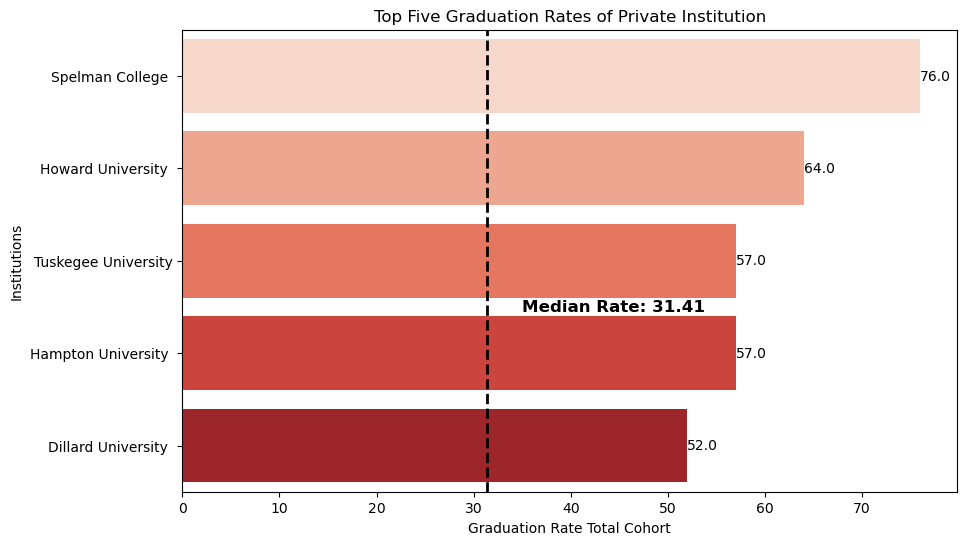

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Graduation_Rate_Total", y="Institution", data=x1, palette="Reds")
plt.xlabel('Graduation Rate Total Cohort')
plt.ylabel('Institutions')
plt.title('Top Five Graduation Rates of Private Institution')
plt.axvline(x=31.41, color='black', linestyle='--', linewidth=2)
plt.text(35, len(x1) / 2, 'Median Rate: 31.41', va='center', ha='left', color='black', fontsize=12, fontweight='bold')

for index, value in enumerate(x1["Graduation_Rate_Total"]):
    plt.text(value, index, str(value), va='center')

plt.savefig('../maps/private_grad_rates.png',bbox_inches='tight',dpi=300)
plt.show()

In [58]:
top_pub_grads=public_grads.iloc[:, 7].nlargest(5)
pub_grads_10=top_pub_grads.reset_index(drop=False)
index_values3 = pub_grads_10['index']
x2=public_grads.loc[index_values3]
cols2= x2.columns.tolist()
cols2[7]="Graduation_Rate_Total"
x2.columns=cols
x2

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Graduation_Rate_Total,Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Xfer_Out_Rate,Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
23,133650,Florida A&M University,FL,1,4-year public,133650,Florida Agricultural and Mechanical University,55.0,28.0,49.0,55.0,22.0,53.0,63.0,63.0,61.0,61.0,NaN
60,199102,North Carolina A&T State University,NC,1,4-year public,199102,North Carolina A & T State University,53.0,29.0,48.0,53.0,24.0,50.0,57.0,57.0,59.0,59.0,NaN
61,199157,North Carolina Central University,NC,1,4-year public,199157,North Carolina Central University,51.0,29.0,47.0,51.0,23.0,50.0,55.0,55.0,51.0,51.0,NaN
69,213598,Lincoln University,PA,1,4-year public,213598,Lincoln University,49.0,32.0,46.0,49.0,29.0,45.0,51.0,51.0,70.0,70.0,NaN
95,234155,Virginia State University,VA,1,4-year public,234155,Virginia State University,48.0,31.0,44.0,48.0,23.0,44.0,55.0,55.0,58.0,58.0,NaN


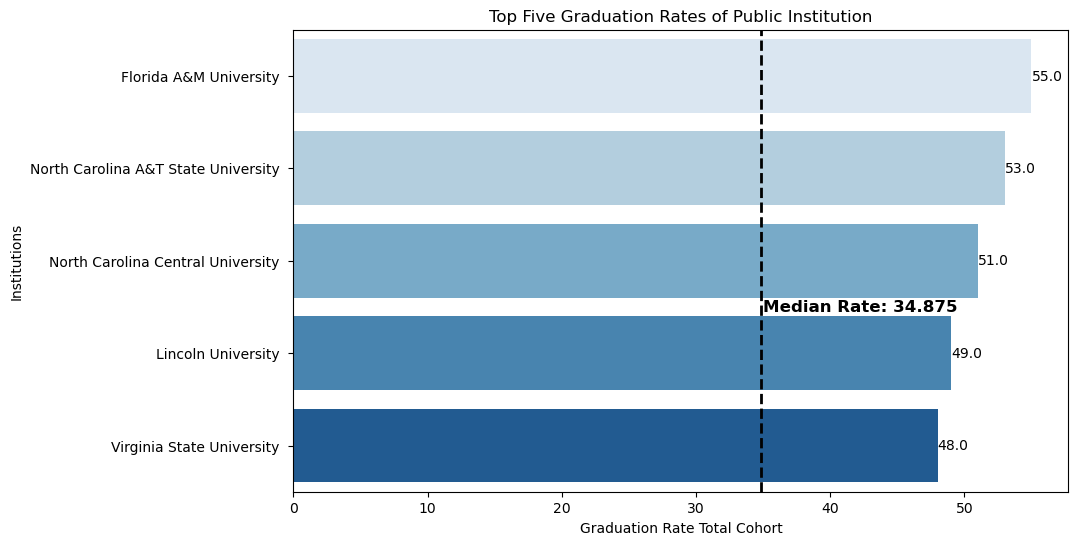

In [63]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Graduation_Rate_Total", y="Institution", data=x2, palette="Blues")
plt.xlabel('Graduation Rate Total Cohort')
plt.ylabel('Institutions')
plt.title('Top Five Graduation Rates of Public Institution')
plt.axvline(x=34.875, color='black', linestyle='--', linewidth=2)
plt.text(35, len(x2) / 2, 'Median Rate: 34.875', va='center', ha='left', color='black', fontsize=12, fontweight='bold')

for index, value in enumerate(x2["Graduation_Rate_Total"]):
    plt.text(value, index, str(value), va='center')
    
plt.savefig('../maps/public_grad_rates.png',bbox_inches='tight',dpi=300)
plt.show()

In [60]:
public_grads.iloc[:, 7].mean()

34.875

In [61]:
private_grads.iloc[:, 7].mean()

31.41304347826087

In [65]:
desig_grad_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 18 columns):
 #   Column                                                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                                                    --------------  -----  
 0   Unnamed: 0                                                                                                                                101 non-null    int64  
 1   Institution                                                                                                                               101 non-null    object 
 2   State                                                                                                                                     101 non-null    object 
 3   Designation                                            

In [68]:
columns2= desig_grad_rates.columns.tolist()
columns2[7]="Graduation_Rate_Total"
columns2[11]="Transfer_Out_Rate_Bach_Cohort"
desig_grad_rates.columns=columns2
desig_grad_rates

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Graduation_Rate_Total,Graduation rate - Bachelor degree within 4 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 5 years total (DRVGR2021_RV),Graduation rate - Bachelor degree within 6 years total (DRVGR2021_RV),Transfer_Out_Rate_Bach_Cohort,Pell Grant recipients - Bachelor's degree rate within 6 years (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Subsidized Stafford Loan recipients not receiving Pell Grants - Bachelor's degree rate within 6 years (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Overall graduation rate within 150 percent of normal time (DRVGR2021_RV),Did not receive Pell Grants or Subsidized Stafford Loans - Bachelor's degree rate within 6 years (DRVGR2021_RV),Unnamed: 12
0,100654,Alabama A&M University,AL,1,4-year public,100654,Alabama A & M University,28.0,11.0,24.0,28.0,34.0,28.0,32.0,32.0,27.0,27.0,NaN
1,100724,Alabama State University,AL,1,4-year public,100724,Alabama State University,28.0,10.0,23.0,28.0,36.0,26.0,40.0,40.0,32.0,32.0,NaN
2,102030,Bishop State Community College,AL,2,2-year public,102030,Bishop State Community College,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN
3,101240,Gadsden State Community College,AL,2,2-year public,101240,Gadsden State Community College,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,NaN,NaN
4,102313,H. Councill Trenholm State Community\n College,AL,2,2-year public,102313,H Councill Trenholm State Community College,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,234164,Virginia Union University,VA,3,4-year private,234164,Virginia Union University,42.0,30.0,40.0,42.0,18.0,38.0,58.0,58.0,53.0,53.0,NaN
97,234137,Virginia University of Lynchburg,VA,3,4-year private,234137,Virginia University of Lynchburg,11.0,0.0,0.0,25.0,NaN,NaN,0.0,NaN,64.0,25.0,NaN
98,237215,Bluefield State College,WV,1,4-year public,237215,Bluefield State University,32.0,17.0,28.0,31.0,9.0,22.0,26.0,20.0,51.0,58.0,NaN
99,237899,West Virginia State University,WV,1,4-year public,237899,West Virginia State University,30.0,18.0,28.0,30.0,20.0,29.0,14.0,14.0,37.0,37.0,NaN


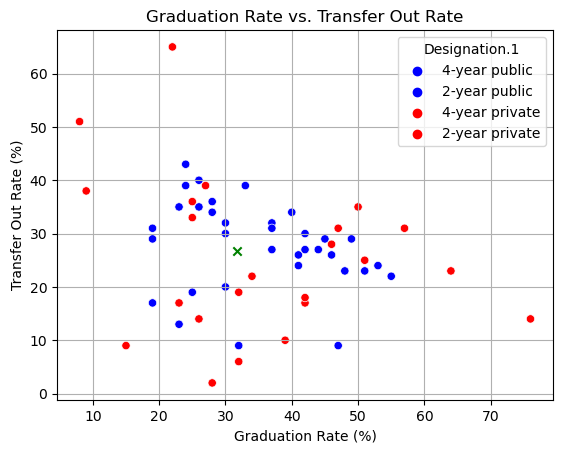

In [80]:
pub_priv_colors = {
    '2-year private': 'red',
    '4-year private': 'red',
    '4-year public': 'blue',
    '2-year public': 'blue'
}
sns.scatterplot(data=desig_grad_rates, x='Graduation_Rate_Total', y='Transfer_Out_Rate_Bach_Cohort', 
                hue='Designation.1', palette= pub_priv_colors)
plt.title('Graduation Rate vs. Transfer Out Rate')
plt.xlabel('Graduation Rate (%)')
plt.ylabel('Transfer Out Rate (%)')

mean_transfer = desig_grad_rates['Transfer_Out_Rate_Bach_Cohort'].mean()
mean_graduation = desig_grad_rates['Graduation_Rate_Total'].mean()
plt.scatter(mean_graduation, mean_transfer, color='green', marker='x', label='Mean')
plt.grid()

plt.savefig('../maps/public_private_grad_xfer_rates.png',bbox_inches='tight',dpi=300)
plt.show()

In [81]:
desig_costs= pd.merge(private_public , costs_by_school, left_on='Unnamed: 0', right_on='UnitID')
#aid_by_school
#public_enroll = desig_enroll[desig_enroll.iloc[:, 3] == 1 | (desig_enroll.iloc[:, 3] == 2)]
desig_costs

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Total price for in-district students living on campus 2021-22 (DRVIC2021),Total price for in-state students living on campus 2021-22 (DRVIC2021),Total price for out-of-state students living on campus 2021-22 (DRVIC2021),Unnamed: 5
0,100654,Alabama A&M University,AL,1,4-year public,100654,Alabama A & M University,24234.0,24234.0,32844.0,NaN
1,100724,Alabama State University,AL,1,4-year public,100724,Alabama State University,22110.0,22110.0,30438.0,NaN
2,102030,Bishop State Community College,AL,2,2-year public,102030,Bishop State Community College,NaN,NaN,NaN,NaN
3,101240,Gadsden State Community College,AL,2,2-year public,101240,Gadsden State Community College,12660.0,12660.0,15612.0,NaN
4,102313,H. Councill Trenholm State Community\n College,AL,2,2-year public,102313,H Councill Trenholm State Community College,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
96,234164,Virginia Union University,VA,3,4-year private,234164,Virginia Union University,29888.0,29888.0,29888.0,NaN
97,234137,Virginia University of Lynchburg,VA,3,4-year private,234137,Virginia University of Lynchburg,26465.0,26465.0,26465.0,NaN
98,237215,Bluefield State College,WV,1,4-year public,237215,Bluefield State University,22971.0,22971.0,30169.0,NaN
99,237899,West Virginia State University,WV,1,4-year public,237899,West Virginia State University,25090.0,25090.0,30778.0,NaN


In [85]:
public_costs = desig_costs[(desig_costs.iloc[:, 3] == 1) | (desig_costs.iloc[:, 3] == 2)]
priv_costs = desig_costs[(desig_costs.iloc[:, 3] == 3) | (desig_costs.iloc[:, 3] == 4)]
priv_costs 

,Unnamed: 0,Institution,State,Designation,Designation.1,UnitID,Institution Name,Total price for in-district students living on campus 2021-22 (DRVIC2021),Total price for in-state students living on campus 2021-22 (DRVIC2021),Total price for out-of-state students living on campus 2021-22 (DRVIC2021),Unnamed: 5
7,101675,Miles College,AL,3,4-year private,101675,Miles College,23144.0,23144.0,23144.0,NaN
8,101912,Oakwood University,AL,3,4-year private,101912,Oakwood University,38564.0,38564.0,38564.0,NaN
9,102058,Selma University,AL,3,4-year private,102058,Selma University,NaN,NaN,NaN,NaN
11,102270,Stillman College,AL,3,4-year private,102270,Stillman College,28052.0,28052.0,28052.0,NaN
12,102298,Talladega College,AL,3,4-year private,102298,Talladega College,27720.0,27720.0,27720.0,NaN
13,102377,Tuskegee University,AL,3,4-year private,102377,Tuskegee University,41924.0,41924.0,41924.0,NaN
14,106306,Arkansas Baptist College,AR,3,4-year private,106306,Arkansas Baptist College,23060.0,23060.0,23060.0,NaN
15,107600,Philander Smith College,AR,3,4-year private,107600,Philander Smith College,26212.0,26212.0,26212.0,NaN
16,107840,Shorter College,AR,4,2-year private,107840,Shorter College,NaN,NaN,NaN,NaN
19,131520,Howard University,DC,3,4-year private,131520,Howard University,48214.0,48214.0,48214.0,NaN


In [89]:
# 7 9
priv_in_state_costs= priv_costs.iloc[:,7].mean() 
priv_out_state_costs= priv_costs.iloc[:,9].mean()
priv_in_state_costs

30067.227272727272

In [90]:
priv_out_state_costs

30067.227272727272

In [91]:
pub_in_state_costs= public_costs.iloc[:,7].mean() 
pub_in_state_costs

22208.090909090908

In [92]:
pub_out_state_costs= public_costs.iloc[:,9].mean() 
pub_out_state_costs

29913.363636363636

In [99]:
costs = [['private_costs', 30067.23, 'private'], ['public_in_state_costs', 22208.09, 'public'], ['public_out_state_costs', 29913.36, 'public']]
 
# Create the pandas DataFrame
costs_df = pd.DataFrame(costs, columns=['cost_type', 'total_price_students_on_campus', 'institution_type'])
costs_df

,cost_type,total_price_students_on_campus,institution_type
0,private_costs,30067.23,private
1,public_in_state_costs,22208.09,public
2,public_out_state_costs,29913.36,public


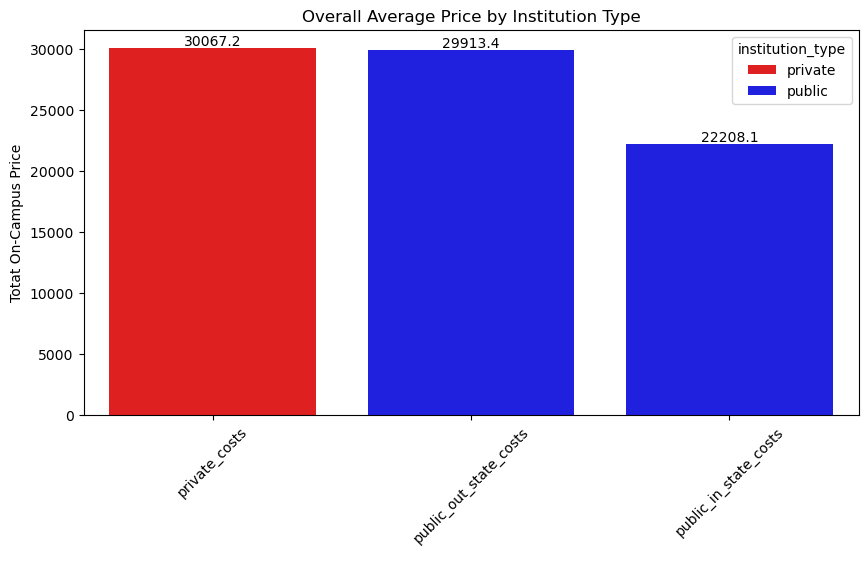

In [127]:
pub_priv_colors2 = {
    'private': 'red',
    'public': 'blue'
}
plt.figure(figsize=(10,5))
costs_df= costs_df.sort_values('total_price_students_on_campus', ascending=False)
ax= sns.barplot(costs_df, x="cost_type", y="total_price_students_on_campus", hue='institution_type',
               palette =pub_priv_colors2,  dodge=False)
ax.set_title('Overall Average Price by Institution Type')
#ax.bar_label(ax.containers[1], fontsize=8);
for i in ax.containers:
    ax.bar_label(i,)
plt.xticks(rotation=45, ha='center')
ax.set(xlabel=' ',ylabel='Totat On-Campus Price')
plt.savefig('../maps/pricing1.png',bbox_inches='tight',dpi=300)